# Análisis de las columnas del archivo de clientes

En este notebook, analizaremos en profundidad las columnas del archivo `data\processed\navegacion_clientes_experimento_limpio.csv`, describiendo su tipo y los valores que contienen. Esto nos ayudará a entender mejor los datos y cómo podemos utilizarlos en nuestro análisis.

## Diccionario de Datos (navegacion_clientes_experimento.csv)

A continuación se describen cada una de las columnas del CSV, su tipo de dato y el significado en el contexto del proyecto de A/B testing para Vanguard.

| **Columna**         | **Tipo**       | **Significado / Descripción**                                                         |
|---------------------|----------------|----------------------------------------------------------------------------------------|
| **client_id**       | `int64`        | Identificador único de cliente. Permite enlazar con otros datasets (ej. clientes.csv). |
| **visitor_id**      | `object` (str) | ID del visitante, normalmente relacionado con el dispositivo/navegador (puede haber múltiples `visitor_id` por `client_id`). |
| **visit_id**        | `object` (str) | ID que identifica cada sesión o visita web concreta.                                   |
| **process_step**    | `object` (str) | Indica la etapa del flujo digital en la que se encuentra el usuario (start, step_1, step_2, step_3, confirm, etc.). |
| **date_time**       | `object` (str) | Marca de fecha/hora en la que se registró la interacción. Se ha homogenizado y puede convertirse a `datetime64[ns]` para análisis de tiempos. |
| **clnt_tenure_yr**  | `int64`        | Años de antigüedad del cliente en la compañía.                                         |
| **clnt_tenure_mnth**| `int64`        | Meses adicionales de antigüedad (más allá de los años completos).                      |
| **clnt_age**        | `float64`      | Edad del cliente en años (puede incluir fracciones para medias estimadas).             |
| **gendr**           | `object` (str) | Género registrado del cliente (p.e. M, F, U).                                          |
| **num_accts**       | `int64`        | Número total de cuentas que el cliente tiene con la compañía.                          |
| **bal**             | `float64`      | Balance total o suma de saldos en todas las cuentas del cliente.                       |
| **calls_6_mnth**    | `int64`        | Cantidad de llamadas realizadas al call center en los últimos 6 meses.                |
| **logons_6_mnth**   | `int64`        | Número de inicios de sesión (logins) en la plataforma en los últimos 6 meses.          |
| **Variation**       | `object` (str) | Indica el grupo experimental al que pertenece el cliente en el A/B test (Test/Control).|

**Notas Adicionales**:
- En el contexto del A/B test, la columna **Variation** es fundamental para diferenciar quién vio la versión clásica (Control) y quién la versión rediseñada (Test).
- La combinación de `client_id` con los campos de navegación (`visitor_id`, `visit_id`, `process_step`, `date_time`) permite analizar la secuencia y frecuencia de pasos de cada cliente, así como el abandono o confirmación del proceso.
- Las columnas de antigüedad (`clnt_tenure_yr`, `clnt_tenure_mnth`), edad (`clnt_age`) y hábitos de uso (`calls_6_mnth`, `logons_6_mnth`) proveen contexto para segmentar y explorar patrones de comportamiento en el flujo digital.


In [2]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
file_path = '../data/processed/navegacion_clientes_experimento_limpio.csv'
clients_df = pd.read_csv(file_path)

# Print column names and types
clients_df.head()

clients_df.shape

(216498, 14)

## Correlación de variables numéricas

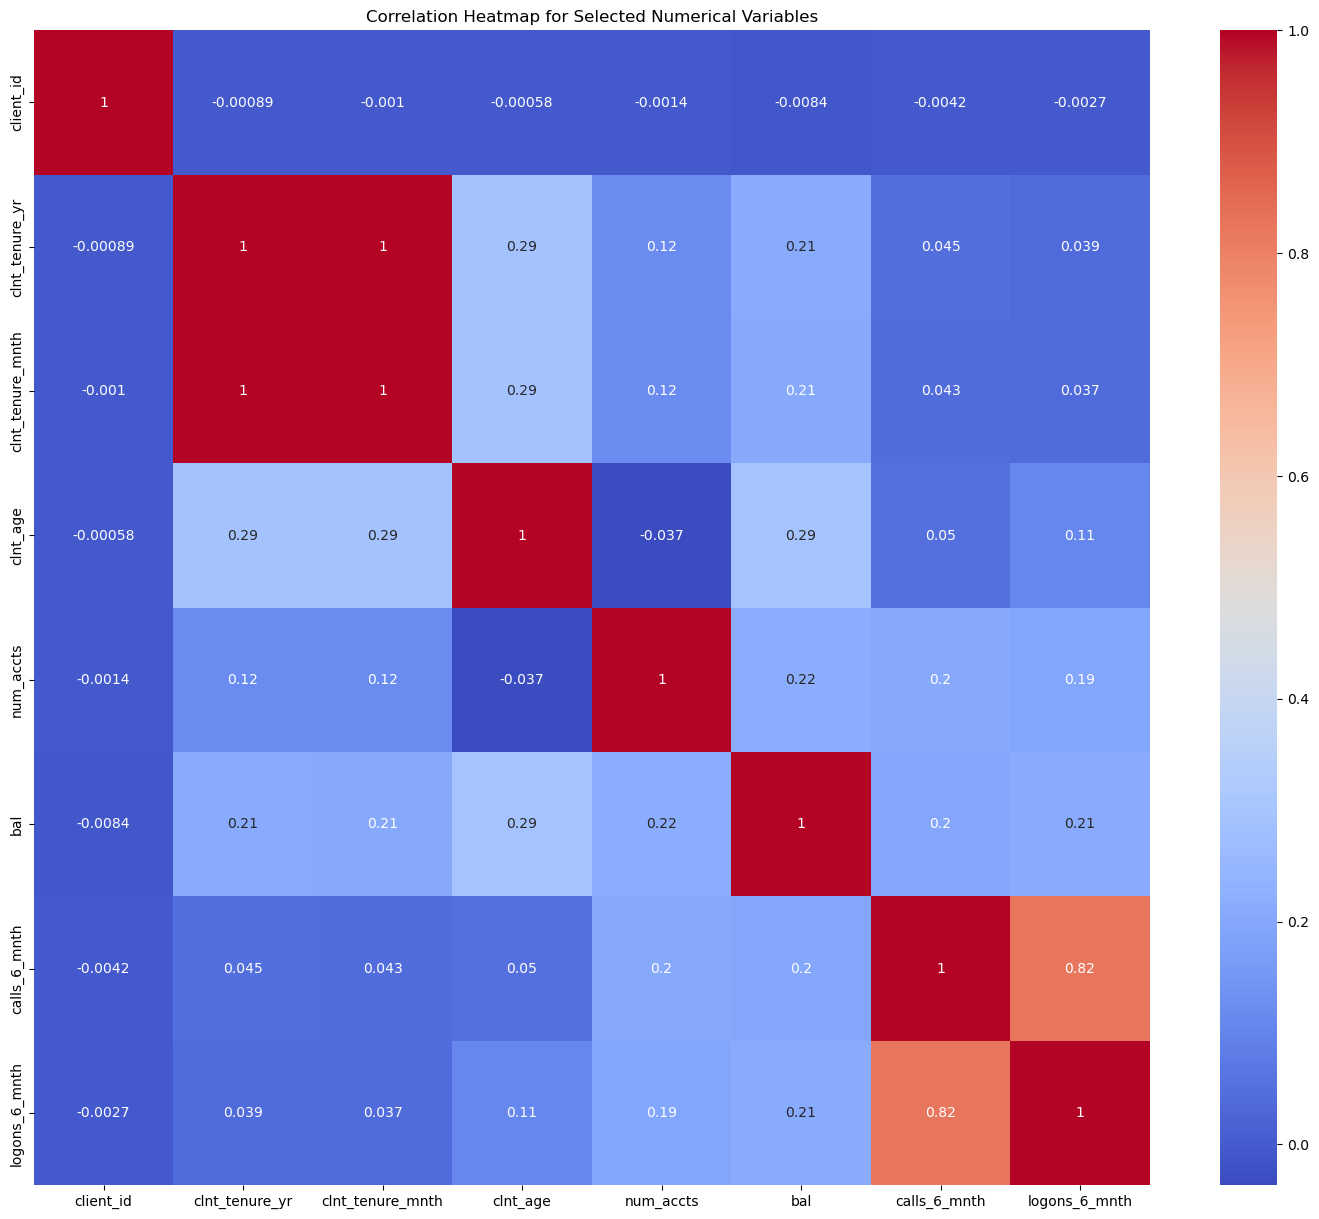

In [2]:
# Capturar las columnas numéricas
df_numerical = clients_df.select_dtypes(include=['int64', 'float64'])

# IMPORTANT: The Spearman correlation coefficient ranges from -1 to 1, where:
correlation_matrix = df_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

## Completion Rate

### Valores de `process_step` y Relación con la Experiencia de Usuario

| **process_step** | **Significado**                                                                                                   | **Relación con la UX**                                                                                                      |
|------------------|-------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| **start**        | Punto de entrada al flujo. Representa el momento en que el usuario inicia la secuencia del proceso (o la sesión). | - Es el primer contacto con la interfaz.<br>- Un diseño poco claro aquí puede generar confusión o abandono inmediato.       |
| **step_1**       | Primer paso tras el arranque. Usualmente implica que el usuario comienza a proporcionar datos o navegar.          | - El usuario debe entender claramente qué se espera de él en este paso.<br>- Un mal diseño puede generar dudas y abandono.  |
| **step_2**       | Segundo paso, donde el usuario avanza a la siguiente fase del flujo (ej. confirmar datos, elegir opciones, etc.). | - Si el usuario repite este paso varias veces, podría indicar falta de claridad.<br>- Problemas de UX aquí generan frustración. |
| **step_3**       | Tercer paso, antesala del final. Suele involucrar un repaso o verificación de información antes de la confirmación final. | - Errores o confusiones en la información mostrada pueden derivar en abandono.<br>- Un paso 3 excesivamente largo podría afectar la finalización. |
| **confirm**      | Paso final. Indica que el proceso se completó exitosamente (p.e. la transacción, suscripción o formulario).       | - Un alto índice de llegada a `confirm` implica una buena experiencia de usuario.<br>- Si pocos usuarios llegan aquí, puede indicar problemas de usabilidad o barreras en pasos anteriores. |

### Valores de `process_step` y su significado

- **start**: Inicio de la sesión o del flujo digital.  
- **step_1**, **step_2**, **step_3**: Pasos intermedios en la secuencia del proceso.  
- **confirm**: Paso final de confirmación, indica que el usuario completó exitosamente el proceso.

### Definición de Abandono

- Se considera **abandono** (Drop-off) cualquier sesión que no llegue al paso `confirm`.  
- Alternativamente, puede segmentarse por fases para saber exactamente en qué transición abandonan los usuarios (entre `start → step_1`, `step_1 → step_2`, `step_2 → step_3` o `step_3 → confirm`).  

## Criterios de Análisis y Métricas Propuestas

A continuación, se describen distintos criterios y métricas clave para comparar los grupos Control vs. Test en el proyecto de A/B testing de Vanguard. Cada métrica incluye una breve explicación y los pasos del proceso digital involucrados.

| **Métrica / Criterio**                             | **Descripción**                                                                                                                | **Cómo calcular**                                                                                                                      |
|----------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------|
| **1. Completion Rate (Tasa de finalización)**      | Porcentaje de sesiones que llegan al paso `confirm`. Un buen indicador de cuántos usuarios completan el flujo.                | - **Numerador**: Número de sesiones con `process_step = "confirm"`.<br>- **Denominador**: Total de sesiones (`visit_id`).<br>- **Fórmula**: `Completion Rate = (# confirm) / (# total sesiones)`. |
| **2. Abandono (Drop-off Rate)**                    | Porcentaje de sesiones que no alcanzan `confirm`. Se interpreta como error o abandono del flujo.                              | - **Drop-off Rate** = 1 − Completion Rate.<br>- O bien, se puede desglosar por cada paso (`start`, `step_1`, `step_2`, `step_3`) para ver en qué fase se produce el abandono. |
| **3. Tiempo total en el flujo (Time to Complete)**  | Tiempo transcurrido entre `start` y `confirm` en cada sesión, indicador de cuán fluido es el proceso.                         | - Convertir `date_time` a formato datetime.<br>- Para cada `visit_id`, restar la marca de tiempo de `confirm` menos la de `start`.<br>- Promediar por grupo Control vs. Test. |
| **4. Error Rate (Tasa de error)**                  | Sesiones con comportamientos anómalos. Puede definirse como aquellas que no llegan a `confirm` o que repiten pasos en exceso. | - Si se define error como “no llegar a confirm”: `Error Rate = (# sesiones sin confirm) / (# total sesiones)`.<br>- Alternativamente, considerar “repetición excesiva de pasos” como error. |
| **5. Repetición de pasos**                         | Mide cuántas veces un usuario repite un mismo paso (p.ej., `step_2` varias veces), lo que podría indicar confusión o bloqueos. | - Para cada sesión, contar cuántas veces aparece cada `process_step`.<br>- Calcular la media o la proporción de sesiones con excesivas repeticiones (>1). |
| **6. Número de llamadas de soporte**               | Refleja cuántas llamadas hace el cliente (columna `calls_6_mnth`), supuesto indicador de complicaciones.                      | - Comparar la media (o distribución) de `calls_6_mnth` entre grupos Test vs. Control.<br>- Hipótesis: un mejor diseño reduce la necesidad de soporte. |
| **7. Logins en 6 meses (logons_6_mnth)**           | Frecuencia de uso de la plataforma en los últimos 6 meses.                                                                    | - Útil para ver si un diseño puede fomentar la adopción a largo plazo, o si hay diferencias notables de usuarios activos entre grupos Test vs. Control.<br>- Comparar la media o distribución (Test vs. Control). |
| **8. Tiempo promedio por paso (Time per Step)**    | Cuánto tarda un usuario en pasar de un paso a otro; podría indicar la claridad o dificultad de cada pantalla.                 | - Convertir `date_time` a datetime.<br>- Ordenar los eventos por `visit_id` y tiempo.<br>- Calcular la diferencia entre `step_i` y `step_{i+1}`.<br>- Promediar o agregar por visita para ver patrones de demora en cada paso. |
| **9. Dificultades por Edad (User Age Segmentation)**| Compara la experiencia (completion, abandono, etc.) según rangos de edad. Permite detectar si usuarios mayores experimentan más problemas. | - Segmentar `clnt_age` en grupos (por ejemplo, “< 35”, “35-55”, “> 55”).<br>- Calcular Completion Rate, Drop-off Rate y/o Tiempo de finalización para cada rango de edad en Test vs. Control.<br>- Verificar diferencias estadísticas. |
| **10. Evolución Temporal (Time-Based Trend)**      | Observa cambios en la tasa de finalización, abandono u otras métricas a lo largo del tiempo del experimento.                  | - Utilizar la columna `date_time` para agrupar por día, semana o mes.<br>- Calcular Completion Rate, Drop-off Rate, etc., en cada intervalo temporal.<br>- Ver si hay mejoras o deterioros con el paso de las semanas (Test vs. Control). |
| **11. Antigüedad del cliente (Client Tenure)**     | Analiza si los clientes más antiguos (mayor `clnt_tenure_yr` + `clnt_tenure_mnth`) tienen diferencias significativas en completación, abandono, etc. frente a clientes más nuevos. | - Crear rangos de antigüedad (p.e. “< 5 años”, “5-10 años”, “> 10 años”).<br>- Comparar Completion Rate, Drop-off Rate o tiempo total en flujo entre grupos Test vs. Control dentro de cada rango de antigüedad.<br>- Determinar si la familiaridad con la marca afecta la adopción del nuevo diseño. |
| **12. Segmentación por Balance (`bal`)**           | Estudia si los usuarios con mayor balance (ingresos/capital) tienen diferente comportamiento frente a la interfaz (Test vs. Control). | - Definir rangos de `bal` (p.e. “< 50k”, “50k-200k”, “> 200k”).<br>- Calcular Completion Rate, Abandono, Tiempo de finalización o llamadas a soporte en cada rango.<br>- Comparar resultados entre grupo Test vs. Control para ver si el balance económico influye en la adopción o éxito del flujo. |

## Métricas Requeridas

La siguiente tabla describe 2 criterios fijos (**A** y **B**) solicitados en el enunciado, más 5 métricas adicionales (**C** a **G**) con sus nombres en español e inglés (o acrónimos) comunes en la industria. De estas últimas, puedes elegir la que más convenga como “tercer criterio” para complementar las dos primeras.

| **Métrica / Criterio**                                          | **Descripción**                                                                                                                                   | **Cómo calcular / Consideraciones**                                                                                                                                                                                                                 |
|-----------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **A) Completion Rate (CR) / Tasa de Finalización**              | Proporción de sesiones que llegan a `confirm`, indicador de cuántos usuarios completan con éxito el proceso (similar a Conversion Rate en ecommerce). | - **Numerador**: Nº de sesiones con `process_step = "confirm"`.<br>- **Denominador**: Nº total de sesiones (`visit_id`).<br>- **Fórmula**: `CR = (# confirm) / (# total sesiones)`.                                                                                                         |
| **B) Cost-Effectiveness (CE) / Umbral de Coste**                | Verifica no solo la finalización, sino si esta es “rentable”, por ejemplo limitando las llamadas de soporte o un coste objetivo.                  | - Definir un umbral de llamadas (`calls_6_mnth`) o un límite de costes por sesión.<br>- Una sesión “exitosa y rentable” debe llegar a `confirm` **y** no superar el umbral.<br>- Comparar la proporción de éxito rentable (CE) entre Test vs. Control.                                  |
| **C) Time to Complete (TTC) / Tiempo de Finalización**          | Mide cuánto tarda un usuario en completar el flujo (de `start` a `confirm`). Es un KPI de usabilidad muy usado en UX.                              | - Convertir `date_time` a datetime.<br>- Para cada `visit_id`, calcular `date_time(confirm) – date_time(start)`.<br>- Promediar y comparar Test vs. Control.<br>- Menor TTC implica potencialmente mejor UX (interfaz más eficiente o clara).                                            |
| **D) Drop-off Rate (DoR) / Tasa de Abandono**                   | Porcentaje de sesiones que no llegan a `confirm`, equivaldría a la inversa de Completion Rate, pero se puede desglosar por pasos del funnel.       | - Como global: `DoR = 1 – CR`.<br>- Desglose por pasos (start, step_1, step_2, etc.).<br>- Útil para ver en qué parte del funnel se produce la mayor parte del abandono.                                                                            |
| **E) Error Rate (ER) / Tasa de Error**                          | Porcentaje de sesiones que experimentan un “error” (puede definirse como no confirmar, reintentos excesivos, o incidentes reportados).            | - Definir el criterio de “error”.<br>- `ER = (# sesiones con error) / (# total sesiones)`.<br>- Un “error” puede incluir abandono temprano, pasos repetidos, o cualquier incidencia significativa para la experiencia.                             |
| **F) Step Repetitions (SR) / Repetición de Pasos**              | Indica cuántas veces un usuario repite un mismo paso (p. ej., `step_2` varias veces), indicador de confusión o bloqueos.                           | - Para cada sesión, contar la frecuencia de cada `process_step`.<br>- Calcular la media o el % de sesiones que repiten pasos > N veces.<br>- Una UI poco clara tiende a más repeticiones de pasos.                                                 |
| **G) Time per Step (TPS) / Tiempo por Paso**                    | Mide el intervalo entre cada `process_step`, útil para detectar dónde el usuario invierte más tiempo o se atasca.                                  | - Ordenar cronológicamente los eventos de cada `visit_id`.<br>- Calcular `t(step_i+1) – t(step_i)`.<br>- Un paso con demasiada duración (TPS alto) podría señalar fricción en la interfaz o complejidad en el formulario.                            |

> **Importante**:
> - El enunciado **exige** las métricas A) CR y B) CE.  
> - La tercera métrica puede ser cualquiera de C) a G), o incluso otra de interés para la empresa (por ejemplo, “CTR” si hubiera datos de clics).  

---

## Segmentaciones (Demográficas y Temporales)

Cuando se comprueba la eficacia del rediseño en las métricas requeridas (A, B, y una tercera al gusto), conviene **segmentar** para detectar qué grupos se benefician más o si hay subgrupos con dificultades específicas:

| **Tipo de Segmentación**            | **Descripción**                                                                                                                                                                                                                                              | **Cómo aplicarlo**                                                                                                                                                                                                                 |
|-------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Género (`gendr`)**                | Comparar CR, CE, TTC, DoR, etc. en M, F, U (si existe).                                                                                                                                                                                                        | - Dividir la muestra por `gendr`.<br>- Volver a calcular CR, CE (o Error Rate, Drop-off Rate, etc.) en cada versión (Test vs. Control).                                                                                            |
| **Edad (`clnt_age`)**               | Clasificar en tramos de edad (p. ej., < 35, 35-55, > 55) para ver si personas mayores tienen más dificultades (ER elevado, DoR) o tardan más (TTC alto).                                                                                                         | - Definir intervalos de edad.<br>- Comparar métricas A, B, C-G en cada subgrupo para Test vs. Control.                                                                                                                             |
| **Balance (`bal`)**                 | Estudiar si usuarios con mayor capital (p. ej., >200k) completan el flujo de forma distinta, abandonan menos o necesitan menos soporte que quienes tienen un balance menor.                                                                                      | - Definir tramos de `bal` (p. ej. <50k, 50k-200k, >200k).<br>- Comparar CR, DoR, TTC, etc. en Test vs. Control para cada rango.                                                                                                     |
| **Antigüedad (`clnt_tenure_yr`)**   | Ver si los clientes con más años en la compañía reaccionan distinto al rediseño que los más nuevos (p. ej., no necesitan tanto soporte, tiempo menor, etc.).                                                                                                     | - Segmentar por rangos de antigüedad (<5 años, 5-10, >10).<br>- Calcular las métricas principales en cada segmento para Test vs. Control.                                                                                         |
| **Número de cuentas (`num_accts`)** | Determinar si los usuarios con múltiples cuentas (>3) tienen un comportamiento diferenciado respecto a los que solo poseen 1 o 2 cuentas (ej. completan antes, menos errores).                                                                                  | - Dividir en grupos 1-2, 3-5, >5 cuentas, etc.<br>- Evaluar CR, DoR, etc. en Test vs. Control.                                                                                                                                     |
| **Evolución temporal**              | Agrupar por día de la semana, hora, semana o mes, para ver si hay variaciones de CR, DoR, TTC, etc. según el momento (laborables vs. fines de semana, picos horarios).                                                                                              | - A partir de `date_time`, extraer `.dt.dayofweek`, `.dt.hour`, `.dt.month`.<br>- Comparar métricas (A, B, C-G) en Test vs. Control segmentadas en esos intervalos.                                                                 |



## KPI

### Definición

- Un KPI (Key Performance Indicator) es un indicador cuantificable que refleja cuán eficaz es una organización o un equipo en relación con un objetivo clave.
- En un proyecto de A/B testing, un KPI mide si la variante nueva (Test) cumple mejor la meta que la versión anterior (Control).

### Ejemplos en este proyecto

- Completion Rate: Podría ser el KPI principal si el objetivo es aumentar la finalización del flujo.
- Cost-Effectiveness: Puede ser otro KPI, si el objetivo es reducir llamadas al call center o costes de soporte.
- Time to Complete: Otro KPI orientado a la usabilidad (un flujo más rápido generalmente es mejor para la experiencia de usuario).

### Relación con tus métricas

- En tu tabla de métricas, todas son potenciales KPIs. Sin embargo, la empresa suele elegir uno o dos (o tres) como KPI principales y trata las demás como métricas secundarias.
- Por ejemplo, es común que la Completion Rate sea el KPI fundamental, y que el “Time to Complete” o “Cost-Effectiveness” sean KPIs secundarios o métricas de apoyo.

### Razón de ser

- El fin de un KPI es tener un número o indicador que muestre con claridad si se está logrando el objetivo de negocio o de producto (p.e., “Queremos incrementar el Completion Rate en un 15%”).
- En un A/B test, se comparan KPIs entre el grupo Control y el grupo Test para comprobar si la variante realmente mejora el rendimiento (p.e., un incremento estadísticamente significativo de la tasa de confirmación).

## KPIs Fundamentales (Principales)

1. **Completion Rate (CR) / Tasa de Finalización**  
   - **Por qué es fundamental**: Refleja cuántos usuarios completan con éxito el proceso (llegan a `confirm`).  
   - **Objetivo de negocio**: Aumentar la conversión final (suscripción, contratación, formulario, etc.).

2. **Cost-Effectiveness (CE) / Efectividad de Coste**  
   - **Por qué es fundamental**: Asegura que el incremento en la tasa de finalización no eleve excesivamente los costes (por ejemplo, llamadas al call center).  
   - **Objetivo de negocio**: Mantener un balance saludable entre volumen de finalizaciones y costes de soporte/operaciones.

## KPIs Secundarios (de Apoyo / Contexto)

1. **Time to Complete (TTC) / Tiempo de Finalización**  
   - Refleja si, aun con alta finalización, el flujo toma demasiado tiempo (posible insatisfacción).

2. **Drop-off Rate (DoR) / Tasa de Abandono**  
   - Indica cuántos usuarios abandonan y en qué paso, complementando la CR.

3. **Error Rate (ER) / Tasa de Error**  
   - Mide cuántos usuarios experimentan errores o atascos (p. ej., no llegan a confirm, repiten pasos, etc.).

4. **Repetición de Pasos (Step Repetitions)**  
   - Expone confusión: si un paso se repite en exceso, puede haber problemas de diseño.

5. **Tiempo por Paso (TPS) / Time per Step**  
   - Indica en qué fase concreta se invierte más tiempo, útil para aislar cuellos de botella.

### Resumen

- Los **KPIs Fundamentales** se centran en **Completion Rate** y **Cost-Effectiveness**, ya que combinan el éxito del proceso y su rentabilidad.  
- Los **KPIs Secundarios** ayudan a explicar en detalle los resultados de los principales e identificar áreas específicas de mejora de UX o eficiencia.  
